# Number of individuals

In this example, we will be seeing how the number of individuals is influencing the simulation time of tstrait. We will also be comparing the simulation time of tstrait and the simulation conducted by using tskit pipelines.

The tree sequence data is being simulated by using `stdpopsim` with the HomSap demographic mode, and we conduct 10 replicates each to examine the computational time.

The codes for the phenotypic simulation by using tskit is based on the simulation codes described in [Martin et al. (2017)](https://doi.org/10.1016/j.ajhg.2017.03.004), but the codes are written more efficiently by using the recent tskit version. The computational time of tskit is evaluated by using 100 Mb human-like chromosomes.

In [1]:
import tstrait
import tskit
import time
import numpy as np
import stdpopsim
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tskit_phenotype import sim_phenotype_tskit

C:\Users\daiki\anaconda3\envs\tstrait\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\daiki\anaconda3\envs\tstrait\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
def compute_time_tstrait(ts):
    times = []
    num_causal = 1000
    trait_model = tstrait.trait_model(distribution="normal", mean=0, var=1)
    for _ in range(10):
        before = time.perf_counter()
        sim_result = tstrait.sim_phenotype(ts, num_causal=num_causal, model=trait_model, h2=0.3)
        duration = time.perf_counter() - before
        times.append(duration)
    return np.array(times)

In [3]:
def compute_time_tskit(ts):
    times = []
    num_causal = 1000
    for i in range(10):
        before = time.perf_counter()
        sim_result = sim_phenotype_tskit(ts=ts, ncausal=num_causal, h2=0.3, random_seed=1+i)
        duration = time.perf_counter() - before
        times.append(duration)
    return np.array(times)

In [4]:
species = stdpopsim.get_species("HomSap")
model = stdpopsim.PiecewiseConstantSize(species.population_size)
engine = stdpopsim.get_engine("msprime")

In [5]:
# tstrait simulation to compile the Python code by using numba
samples = {"pop_0": 100}
contig = species.get_contig(length=1_000_000)
ts = engine.simulate(model, contig, samples)
trait_model = tstrait.trait_model(distribution="normal", mean=0, var=1)
sim_result = tstrait.sim_phenotype(ts, num_causal=5, model=trait_model, h2=0.3)

In [6]:
time_result = {}

In [7]:
length_array = [50, 100, 200]
num_ind_array = [1000, 5000, 10_000, 25_000, 50_000, 100_000]

# Obtaining tstrait simulation time
for length, num_ind in itertools.product(length_array, num_ind_array):
    samples = {"pop_0": num_ind}
    contig = species.get_contig(length=1_000_000*length)
    ts = engine.simulate(model, contig, samples)
    time_result["{}_{}Mb".format(num_ind, length)] = compute_time_tstrait(ts)
    if length == 100:
        time_result["tskit_{}_100Mb".format(num_ind)] = compute_time_tskit(ts)

In [8]:
time_df = pd.DataFrame(time_result)
time_df.to_csv("output/simulation_time.csv")

In [9]:
mean_time = time_df.mean()
lowci_time = time_df.apply(lambda x: np.mean(x)-1.96*np.std(x)/np.sqrt(10))
highci_time = time_df.apply(lambda x: np.mean(x)+1.96*np.std(x)/np.sqrt(10))

In [10]:
# Reorder array based on the ordering of the num_ind_array
def reorder_array(array, name):
    result = []
    for ind in num_ind_array:
        result.append(array["{}_{}Mb".format(ind, name)])
    return result

def reorder_tskit_array(array):
    result = []
    for ind in num_ind_array:
        result.append(array["tskit_{}_100Mb".format(ind)])
    return result

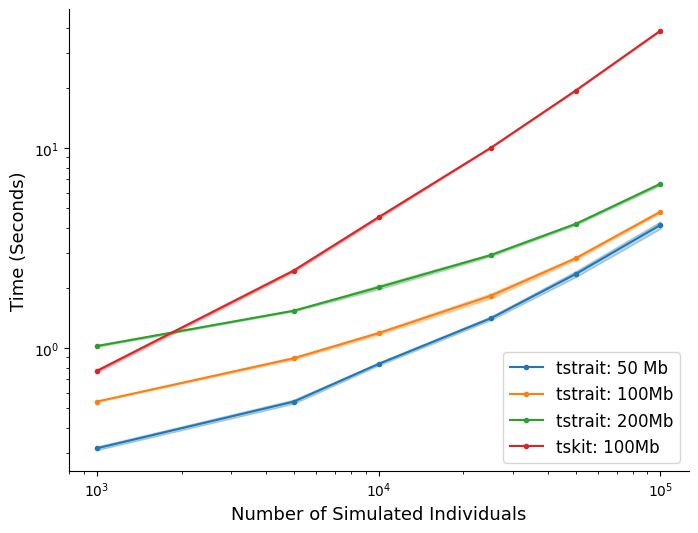

In [11]:
fig, axs = plt.subplots(figsize=(8,6))

axs.plot(num_ind_array, reorder_array(mean_time, name="50"), label="tstrait: 50 Mb", marker=".", color="tab:blue")
axs.fill_between(num_ind_array, reorder_array(lowci_time, name="50"), reorder_array(highci_time, name="50"), color='tab:blue', alpha=.3)
axs.loglog(num_ind_array, reorder_array(mean_time, name="100"), label="tstrait: 100Mb", marker=".", color="tab:orange")
axs.fill_between(num_ind_array, reorder_array(lowci_time, name="100"), reorder_array(highci_time, name="100"), color='tab:orange', alpha=.3)
axs.loglog(num_ind_array, reorder_array(mean_time, name="200"), label="tstrait: 200Mb", marker=".", color="tab:green")
axs.fill_between(num_ind_array, reorder_array(lowci_time, name="200"), reorder_array(highci_time, name="200"), color='tab:green', alpha=.3)

axs.loglog(num_ind_array, reorder_tskit_array(mean_time), label="tskit: 100Mb", marker=".", color="tab:red")
axs.fill_between(num_ind_array, reorder_tskit_array(lowci_time), reorder_tskit_array(highci_time), color='tab:red', alpha=.3)



#axs.loglog(previous_num_ind, tskit_df.mean(), label="tskit", marker=".", color="tab:blue")
#axs.fill_between(previous_num_ind, lowci_tskit, highci_tskit, color='tab:blue', alpha=.3)
axs.set_xlabel('Number of Simulated Individuals', fontsize=13)
axs.set_ylabel('Time (Seconds)', fontsize=13)
#axs.set_ylim((0,500))
axs.legend(loc="lower right", prop={'size': 12})
axs.spines["top"].set_visible(False)
axs.spines["right"].set_visible(False)
#axs.set_title("Genomic length: 100 Mb, 1000 Causal Sites", fontsize=16)
plt.savefig("stdpopsim-time.pdf", bbox_inches="tight")